# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io


# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import PlantDetection

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "models/plant2.h5"  # TODO: update this path

## Configurations

In [ ]:
config = PlantDetection.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "pictures/Plants")

In [ ]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [ ]:
# Load validation dataset
dataset = PlantDetection.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Goldenseal']
numids [1]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
objects: ['Blackcohosh']
numids [3]
Images: 28
Classes: ['BG', 'Goldenseal', 

## Load Model

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = BALLON_WEIGHTS_PATH

# Or, load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  models/plant2.h5


## Run Detection

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: Tildee.fuupra9kfjy31.jpg (17) /content/drive/My Drive/Colab Notebooks/capstone files/pictures/Plants/val/fuupra9kfjy31.jpg


In [ ]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "pictures/Goldenseal/test")
file_names = next(os.walk(IMAGE_DIR))[2]

In [ ]:
dataset.class_names

['BG', 'Goldenseal', 'Ginseng', 'Blackcohosh']

In [ ]:
if r['class_ids'] == gt_class_id[0]:
  print('True')

True


image ID: Tildee.484456478_f579352aee_c.jpg (21) /content/drive/My Drive/Colab Notebooks/capstone files/pictures/Plants/val/484456478_f579352aee_c.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:  155.00000  max: 1014.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


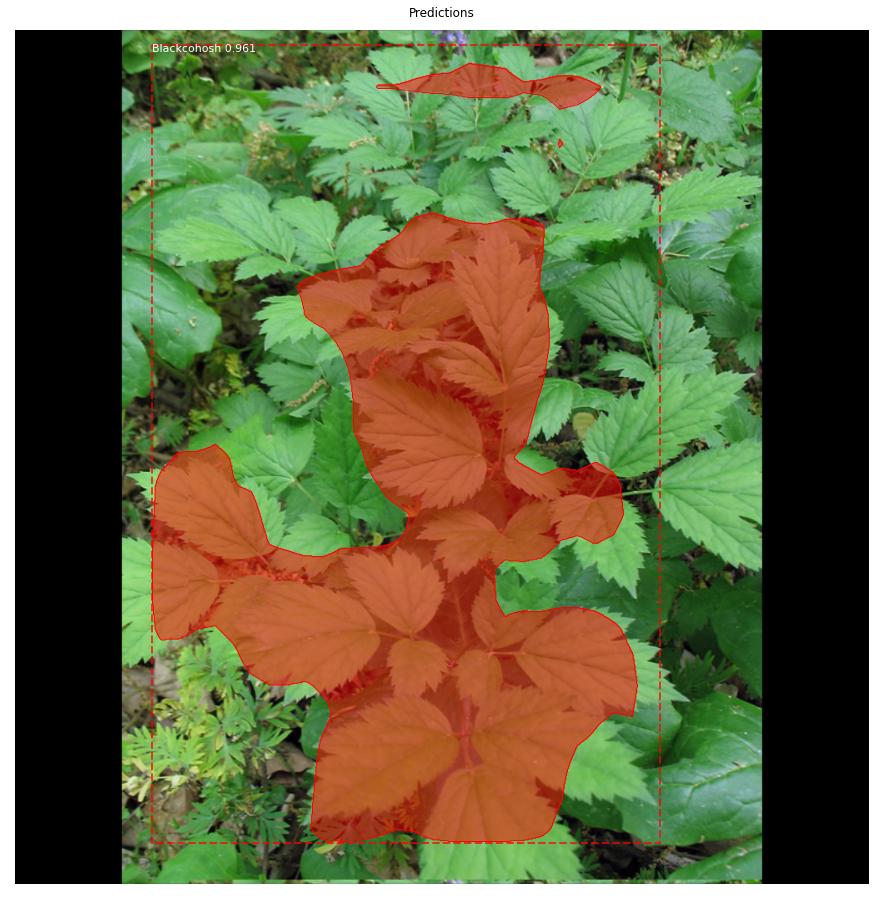

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
# This is for predicting images which are not present in dataset
#image_id = random.choice(dataset.image_ids)
image1 = skimage.io.imread('pictures/Plants/test/opencv_frame_26.png')

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

    # Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset.class_names, r1['scores'], ax=ax,
                            title="Predictions1")
print(r1['class_ids'])

In [ ]:
# Load validation dataset
dataset = PlantDetection.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset.prepare()

Gold_correct_count = 0
Gin_correct_count = 0
Cohosh_correct_count = 0
Gold_incorrect_count = 0
Gin_incorrect_count = 0
Cohosh_incorrect_count = 0
incorrect_count = 0
#to test how well the model works
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
  info = dataset.image_info[image_id]
  # Run object detection
  results = model.detect([image], verbose=1)
  # Display results
  r = results[0]
  try:
    if r['class_ids'] == gt_class_id[0] and gt_class_id == 1:
      Gold_correct_count += 1
    elif r['class_ids'] != gt_class_id[0] and gt_class_id == 1:
      Gold_incorrect_count += 1
    if r['class_ids'] == gt_class_id[0] and gt_class_id == 2:
      Gin_correct_count += 1
    elif r['class_ids'] != gt_class_id[0] and gt_class_id == 2:
      Gin_incorrect_count += 1
    if r['class_ids'] == gt_class_id[0] and gt_class_id == 3:
      Cohosh_correct_count += 1
    elif r['class_ids'] != gt_class_id[0] and gt_class_id == 3:
      Cohosh_incorrect_count += 1
    else:
      incorrect_count += 1
  except:
    incorrect_count += 1

objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects: ['Ginseng']
numids [2]
objects:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000

In [ ]:
print("Goldenseal ids correctly guessed: ",Gold_correct_count)
print("Ginseng ids correctly guessed: ",Gin_correct_count)
print("Black Cohosh ids correctly guessed: ",Cohosh_correct_count)
print("Goldenseal ids incorrectly guessed: ",Gold_incorrect_count)
print("Ginseng ids incorrectly guessed: ",Gin_incorrect_count)
print("Black Cohosh ids incorrectly guessed: ",Cohosh_incorrect_count)
print("ids unable to be guessed: ",incorrect_count)

Goldenseal ids correctly guessed:  54
Ginseng ids correctly guessed:  33
Black Cohosh ids correctly guessed:  38
Goldenseal ids incorrectly guessed:  3
Ginseng ids incorrectly guessed:  3
Black Cohosh ids incorrectly guessed:  0
ids unable to be guessed:  108


now to get the physical position (in a 1080p camera)

In [ ]:
print("the start of the plant is at ", r1['rois'][0][1]/101, "cm")
print("the end of the plant is at ", r1['rois'][0][3]/101, "cm")
print("X pixel indent",r1['rois'][0][1])
print("X pixel ending",r1['rois'][0][3])

the start of the plant is at  3.3564356435643563 cm
the end of the plant is at  13.237623762376238 cm
X pixel indent 339
X pixel ending 1337
